In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

track_metadata_df = pd.read_csv('data/song_data.csv')
count_play_df = pd.read_csv('data/10000.txt', sep='\t', header=None, names=['user','song_id','play_count'])

print('First see of track metadata:')
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
track_metadata_df.head()

First see of track metadata:
Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [ ]:
print('Note the problem with repeated track metadata. Let\'s see of counts play song by users:')
count_play_df.head()

Note the problem with repeated track metadata. Let's see of counts play song by users:


,user,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [7]:
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

In [8]:
print('Number of rows after unique song Id treatment:', unique_track_metadata_df.shape[0])
print('Number of unique songs:', len(unique_track_metadata_df.song_id.unique()))
unique_track_metadata_df.head()

Number of rows after unique song Id treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOAAABI12A8C13615F,Afro Jazziac,To Birdland And Hurry,Herbie Mann,2000
1,SOAAABT12AC46860F0,Herre Gud Ditt Dyre Namn Og Ære,Som Den Gyldne Sol Frembryter,Bergen Big Band,0
2,SOAAABX12A8C13FEB2,N.Y.C. Remix,Paris Can´t Wait,Guardner,0
3,SOAAACR12A58A79456,Irresistible,Wowie Zowie,Superchumbo,2002
4,SOAAACY12A58A79663,Untitled 1,Pine Cone Temples,Thuja,0


In [9]:
user_song_list_count = pd.merge(count_play_df,
                                unique_track_metadata_df, how='left',
                                left_on='song_id',
                                right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])


In [10]:
user_song_list_count.head()

,user,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [11]:
user_song_list_count.listen_count.describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,2000000.0,3.045485,6.57972,1.0,1.0,1.0,3.0,2213.0


In [12]:
print('{:d} users, {:.2%} of total play counts, listen to a single more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T

118 users, 0.01% of total play counts, listen to a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,140.0,327.107143,209.11467,201.0,225.0,267.0,353.75,2213.0


In [13]:
lunatic = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
track_metadata_df[track_metadata_df.song_id.isin(
                  count_play_df[count_play_df.play_count>count_play_df.play_count.max()-10].song_id.values)]

- How much days the most obsessed user can be the fan of a unique song: 5.4


,song_id,title,release,artist_name,year
567847,SOFCGSE12AF72A674F,Starshine,Gorillaz,Gorillaz,2000


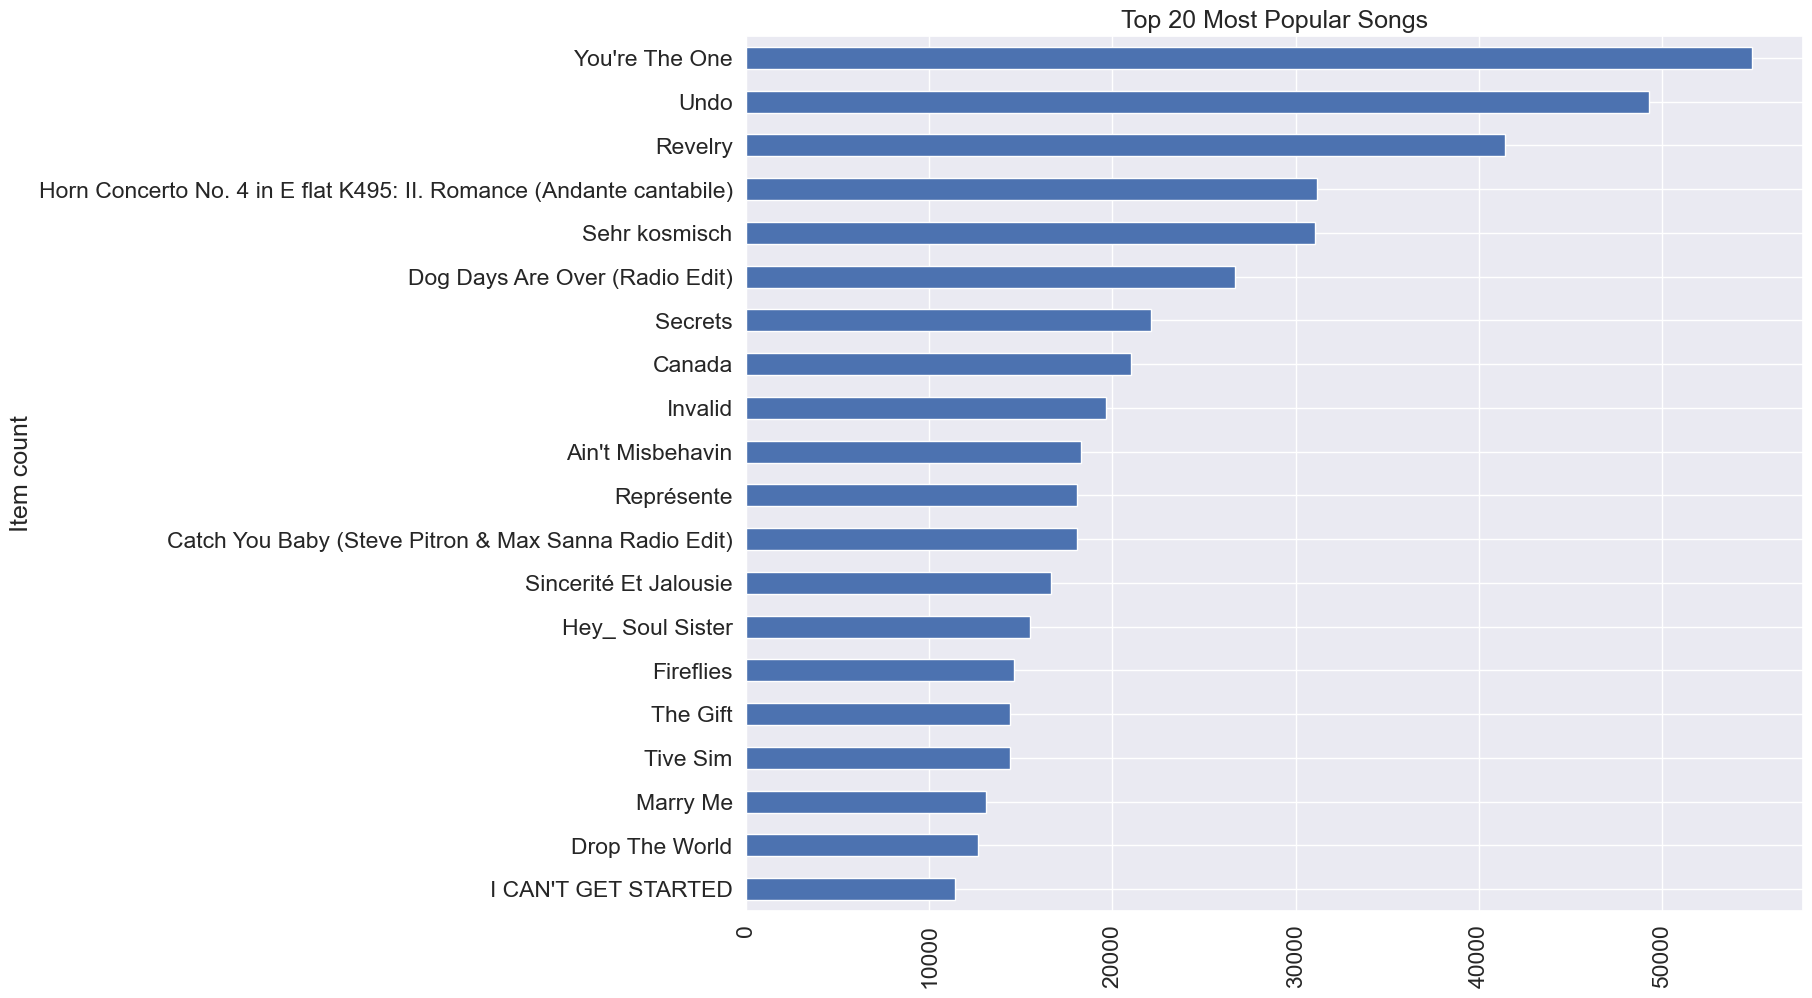

In [14]:
fig = plt.figure(figsize=(30, 25))

Graph1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
fig1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=Graph1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

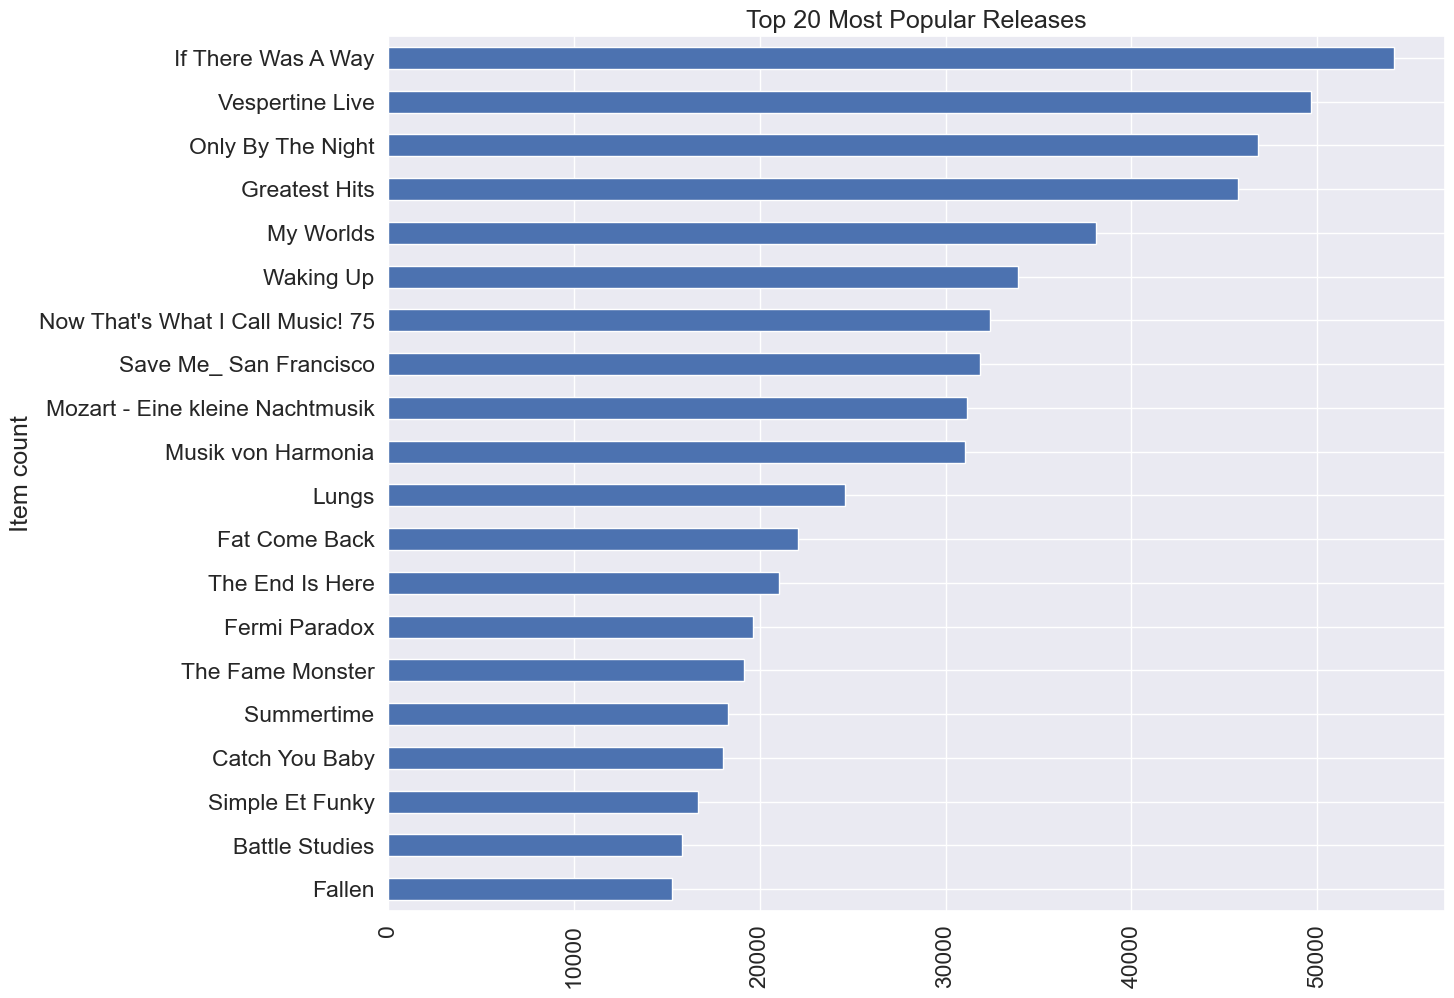

In [24]:
fig = plt.figure(figsize=(30, 25))

Graph2 = fig.add_subplot(221)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
fig2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=Graph2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

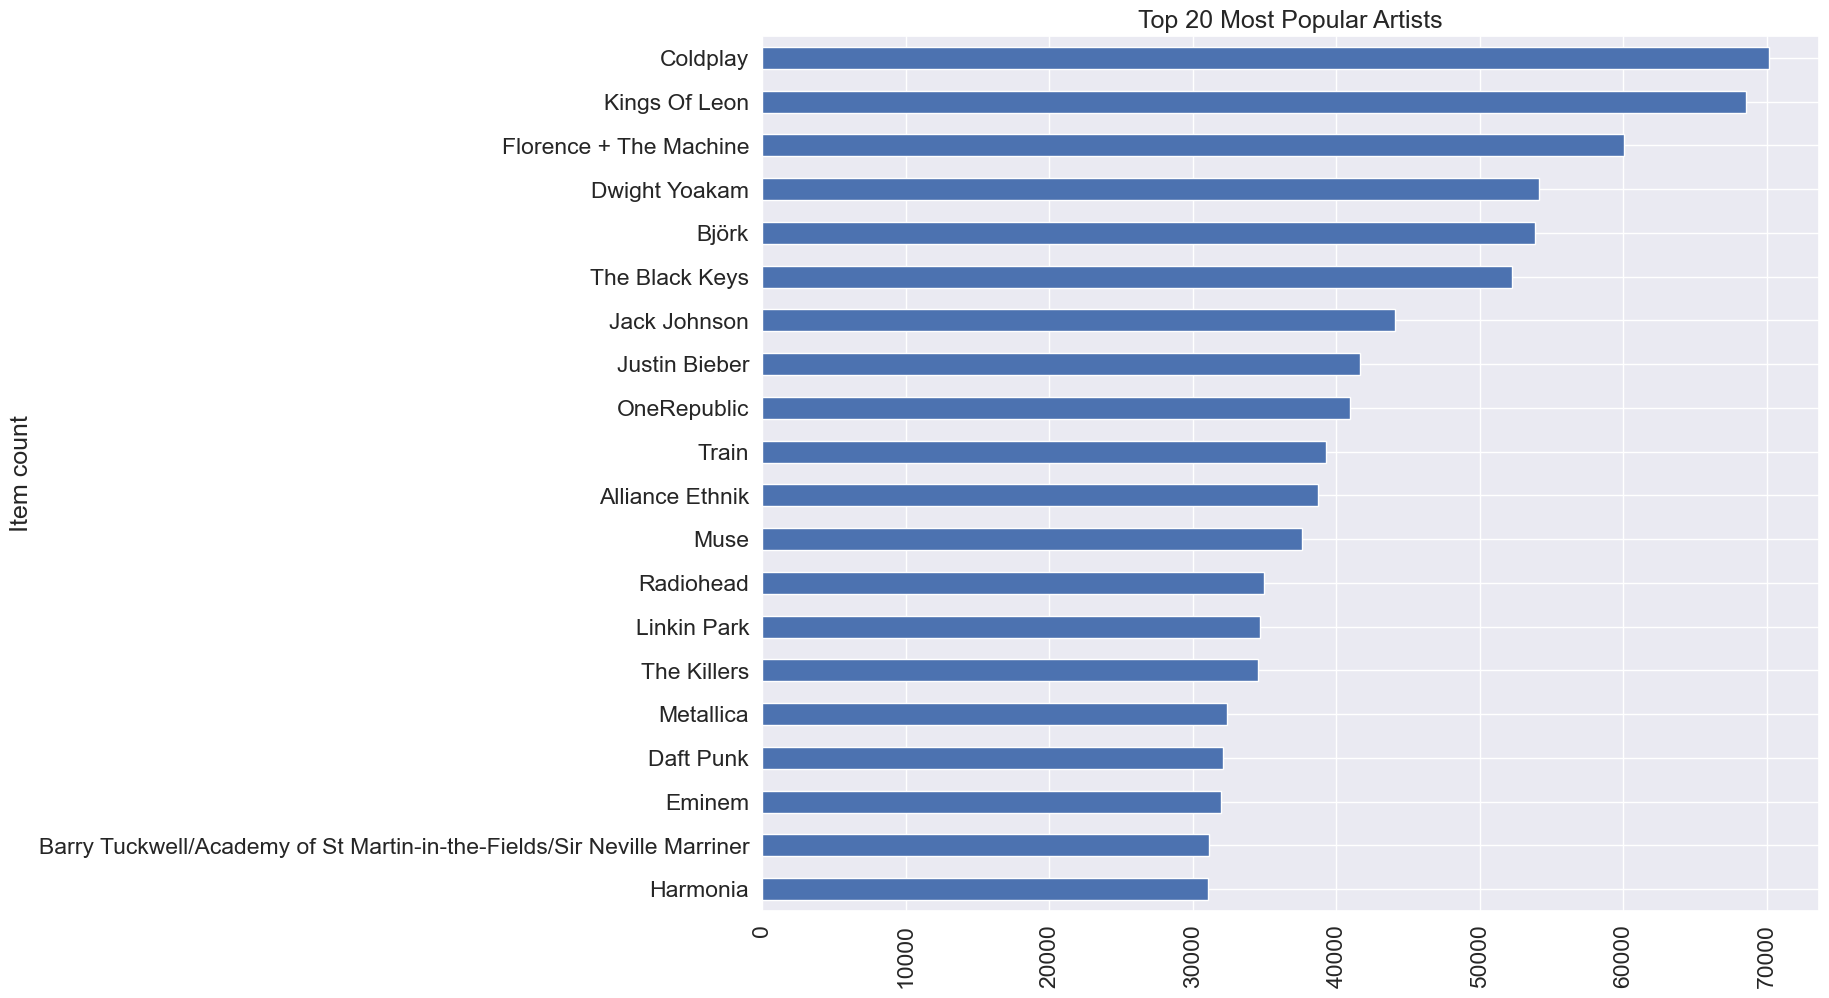

In [27]:
fig = plt.figure(figsize=(30, 25))

Graph3 = fig.add_subplot(221)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
fig1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=Graph3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

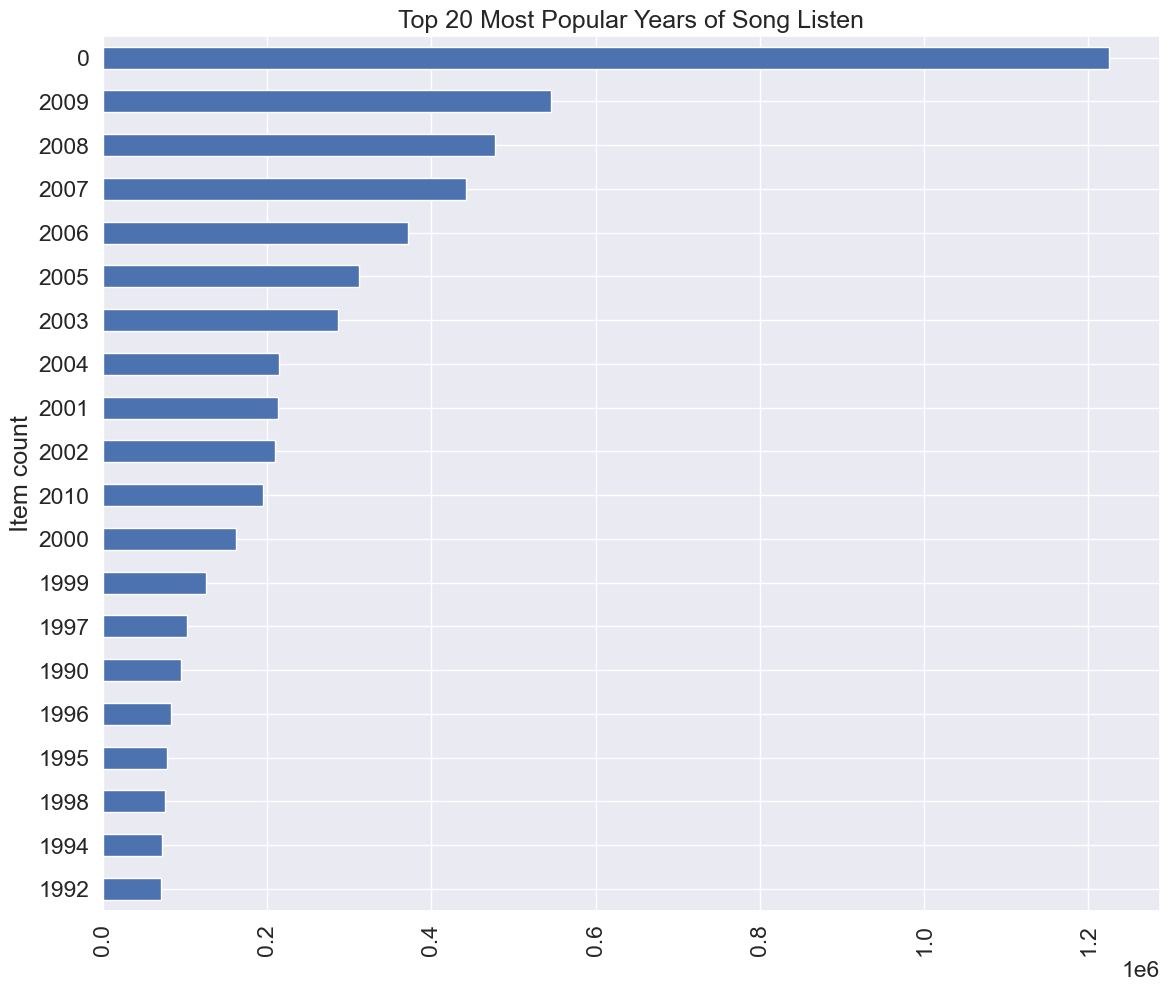

In [23]:
fig = plt.figure(figsize=(30, 25))

Graph4 = fig.add_subplot(221)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
fig1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=Graph4)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

c:\users\rapho\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


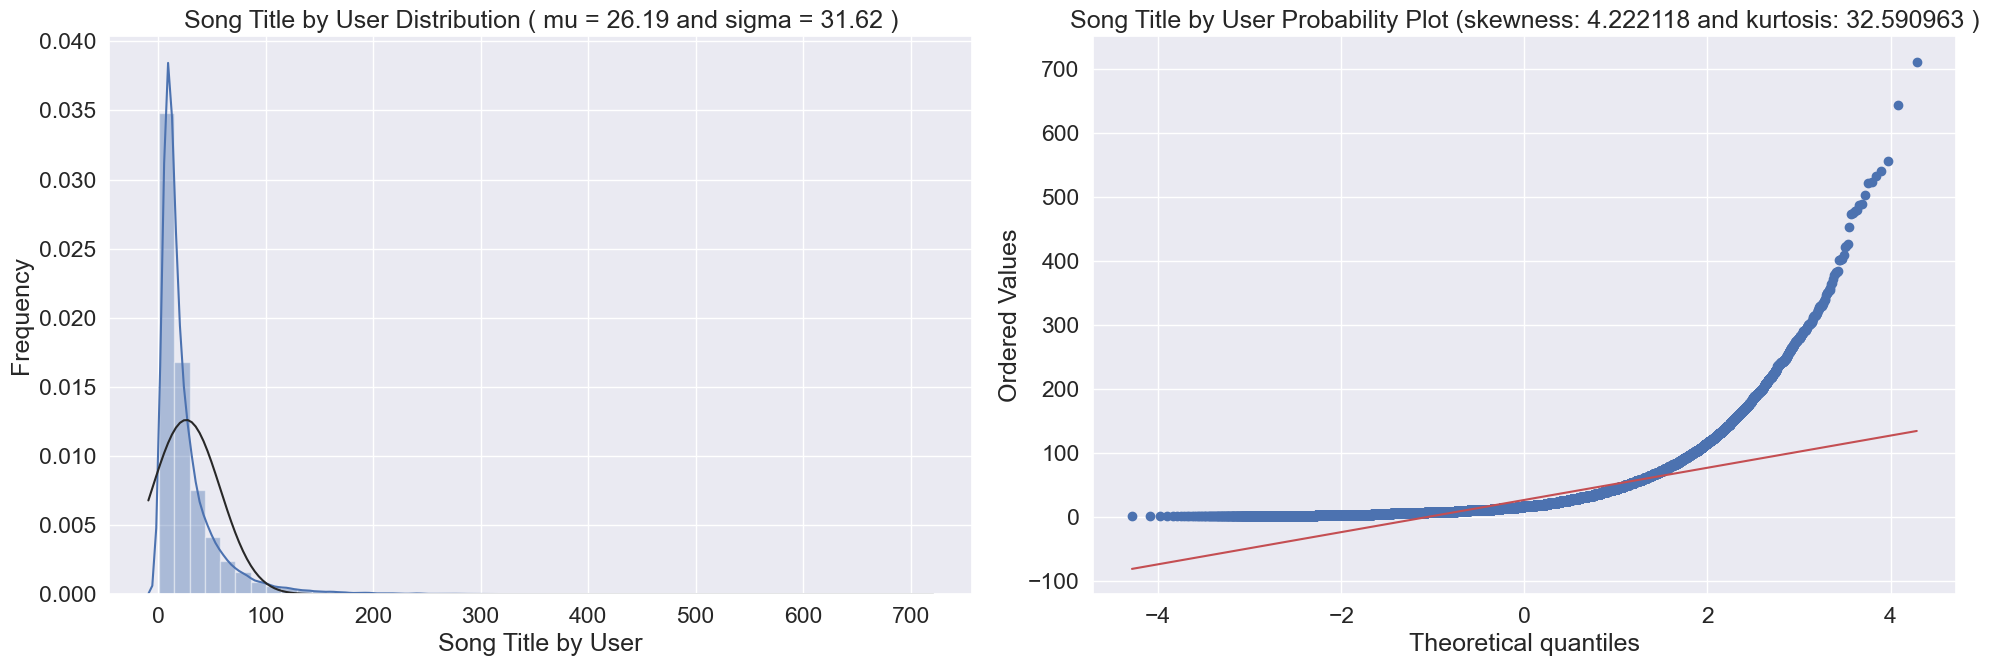

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,76353.0,26.194125,31.625078,1.0,9.0,16.0,31.0,711.0


In [17]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T

In [18]:
def create_popular_recommender(train_data, user_id, item_id):

    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)

    #Sorts the songs based on the recommendation score
    train_data_sorting = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])

    #Generates a recommendation rank based on the score
    train_data_sorting['Rank'] = train_data_sorting.score.rank(ascending=0, method='first')

    #Gets the top 10 recommendations
    popular_recommendations = train_data_sorting.head(10)

    return popular_recommendations

In [22]:
recommendations = create_popular_recommender(user_song_list_count,'user','title')
recommendations

,title,score,Rank
6837,Sehr kosmisch,8277,1.0
8726,Undo,7032,2.0
1965,Dog Days Are Over (Radio Edit),6949,3.0
9497,You're The One,6729,4.0
6499,Revelry,6145,5.0
6826,Secrets,5841,6.0
3438,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,7.0
2596,Fireflies,4795,8.0
3323,Hey_ Soul Sister,4758,9.0
8495,Tive Sim,4548,10.0


In [23]:
create_popular_recommender(user_song_list_count,'user','artist_name')

,artist_name,score,Rank
649,Coldplay,29422,1.0
2850,The Black Keys,19862,2.0
1651,Kings Of Leon,18747,3.0
1107,Florence + The Machine,18112,4.0
1370,Jack Johnson,17801,5.0
2946,The Killers,16063,6.0
2374,Radiohead,14890,7.0
736,Daft Punk,14715,8.0
2073,Muse,14005,9.0
1554,Justin Bieber,13959,10.0
